In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_ENABLE_ONEDNN_OPTS'] =  "0"

import numpy as np
import seaborn as sns
import sys
#import cv2 as cv2
import glob
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import gc
import keras
from sklearn.model_selection import train_test_split

import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

import os

print(tf.__version__)

## Uso de GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2024-05-09 23:49:23.145757: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-09 23:49:23.145953: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-09 23:49:23.151602: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-09 23:49:23.516331: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2.14.0


2024-05-09 23:49:26.529550: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-09 23:49:26.590027: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-09 23:49:26.590205: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

(1836, 1836, 3)


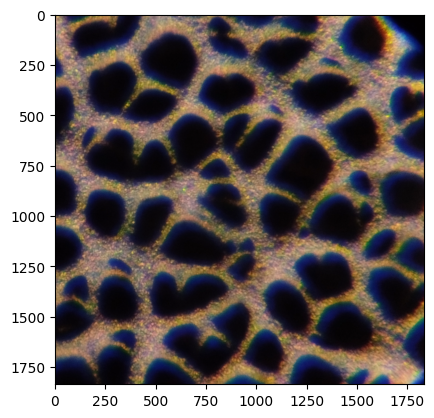

In [2]:
#https://www.askpython.com/python-modules/python-patchify
#https://pypi.org/project/patchify/
### Función que recibe una imagen PIL de keras, y retorna la misma imagen PIL recortada
def cropping(image,crop_perc = 0.275,resize=1):  
    
    ## tamaño de la imagen
    px = np.shape(image)[0]
    py = np.shape(image)[1]
    
    ## verificar que la imagen sea horizontal, si no rotar y guardar nuevos tamaños de px y py
    if px > py:
        image = image.rotate(90)
        px = np.shape(image)[0]
        py = np.shape(image)[1]
        
    ## Recortar la imagen
    vert_sup = int(px*crop_perc)
    vert_inf = int(px - px*crop_perc)
    htal_izq = int(py*crop_perc)
    htal_der = int(py - py*crop_perc)
    
    ## verificar que la imagen quede cuadrada 
    if vert_inf-vert_sup > htal_der-htal_izq:
        dif = vert_inf-vert_sup - (htal_der-htal_izq)
        htal_der = htal_der + dif
    else:
        dif = htal_der-htal_izq - (vert_inf-vert_sup)
        vert_inf = vert_inf + dif
        
    
    # Construcción de la nueva imágen
    im_array = tf.keras.preprocessing.image.img_to_array(image)
    nim_array = tf.keras.preprocessing.image.array_to_img(im_array[vert_sup:vert_inf,htal_izq:htal_der])
    
    return nim_array

### Rutas
cnt = 0
routes = []
classes = []
foam_number = []## Uso de GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)
rutas_dataset  = glob.glob('../../../Datasets/Micrografías macroproperties/originales/*/*/*.jpg')
for img in rutas_dataset:
    route = img
    clss = img.split('/')[-3]
    foam = img.split('/')[-2]
    routes.append(route)
    classes.append(clss)
    foam_number.append(foam)

##Creación del dataframe
data = pd.DataFrame({'route':routes,'class':classes,'foam_number':foam_number}) 


## recortar una imagen
img = tf.keras.preprocessing.image.load_img(data['route'][0])
img = cropping(img)
print(np.shape(img))
plt.imshow(img)
plt.show()    

In [4]:
data

,route,class,foam_number
0,../../../Datasets/Micrografías macroproperties...,MF2,4
1,../../../Datasets/Micrografías macroproperties...,MF2,4
2,../../../Datasets/Micrografías macroproperties...,MF2,4
3,../../../Datasets/Micrografías macroproperties...,MF2,4
4,../../../Datasets/Micrografías macroproperties...,MF2,4
...,...,...,...
537,../../../Datasets/Micrografías macroproperties...,MF3,4
538,../../../Datasets/Micrografías macroproperties...,MF3,4
539,../../../Datasets/Micrografías macroproperties...,MF3,4
540,../../../Datasets/Micrografías macroproperties...,MF3,4


In [5]:
## Recortar las imágenes
# ruta para guardar las imagenes 
save_route = '../../../Datasets/Micrografías macroproperties/recortadas/'
for i in range(len(data)):
    # guardar nombre de la imagen
    name = data['route'][i].split('/')[-1]
    # Cargar imagen with tensor tf
    img = tf.keras.preprocessing.image.load_img(data['route'][i])
    # Recortar imagen
    img = cropping(img)
    # Guardar imagen en carpetas por clase y foam
    # crear carpeta si no existe y guardar imagen
    if not os.path.exists(save_route+data['class'][i]+'/'+data['foam_number'][i]):
        os.makedirs(save_route+data['class'][i]+'/'+data['foam_number'][i])
        img.save(save_route+data['class'][i]+'/'+data['foam_number'][i]+'/'+name)
    else:
        img.save(save_route+data['class'][i]+'/'+data['foam_number'][i]+'/'+name)

../../../Datasets/Micrografías macroproperties/originales/MF2/2/IMG_20230711_174523.jpg
../../../Datasets/Micrografías macroproperties/recortadas/MF2/2/IMG_20230711_174523.jpg
(4080, 3072, 3) (1836, 1836, 3)


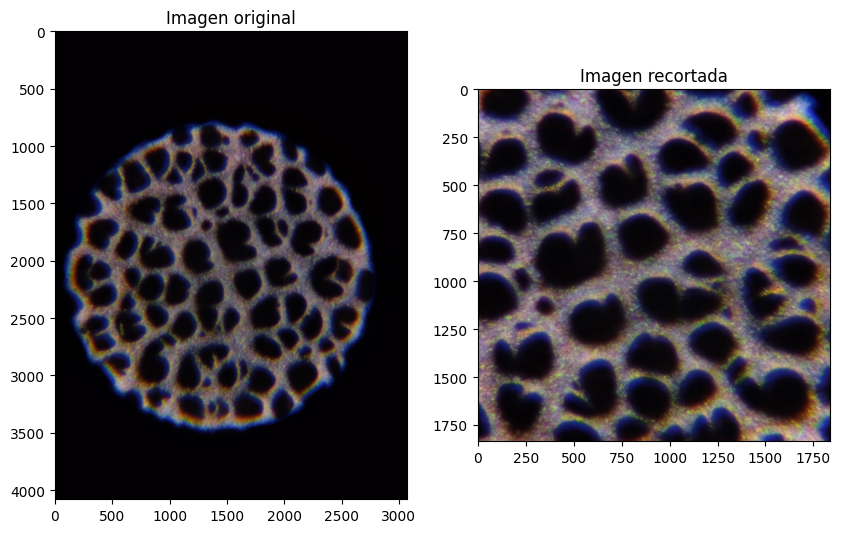

In [12]:
### visualizar imágen original y su recortada
img_routes = glob.glob('../../../Datasets/Micrografías macroproperties/originales/*/*/*.jpg')
## Capturar los datos de la imagen original
n = 100
nombre = img_routes[n].split('/')[-1]
clase = img_routes[n].split('/')[-3]
foam = img_routes[n].split('/')[-2]

## ruta imagen recortada
ruta_cropped = '../../../Datasets/Micrografías macroproperties/recortadas/'+clase+'/'+foam+'/'+nombre


## imprimir nombres de las imágenes
 
print(img_routes[n])
print(ruta_cropped)

## seleccioanr una imagen
img = tf.keras.preprocessing.image.load_img(img_routes[n])
img_c = tf.keras.preprocessing.image.load_img(ruta_cropped)

print(np.shape(img),np.shape(img_c))

## visualizar
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Imagen original')
plt.subplot(1,2,2)
plt.imshow(img_c)
plt.title('Imagen recortada')
plt.show()